# 分類問題の概要

この章では、分類問題についての概要と、線形二値分類、ロジスティック回帰などについて説明する。  
分類とはその名の通り、データから真偽値(2値)を判定したり、何らかのカテゴリに分類したりすることを指す。
例えば、動物の写真を与えて犬かどうかを判定する場合や、
ラーメンの写真から、醤油系・味噌系・塩系などのカテゴリに分類する場合などを想像すると良い。

我々は普段、このような分類問題を無意識に解いているが、
それをコンピュータを用いて機械的に判定するためにはどうすればよいか。  
その基礎づけを与えることが、この章の主眼である。

## 線形二値分類

まずは、最も単純な分類問題である、二値分類を考える。
二値分類とは、データが2つのカテゴリのどちらかに属するかを判定する問題である。  
分類の際、注目したいラベルやカテゴリが２値を取る場合というのは、真偽値を判定する問題と等価である。

以下では例として、身長と体重という2つの特徴量を持つ疑似データを考え、
それらの特徴量から、その人が成人か未成年かを判定してみよう。

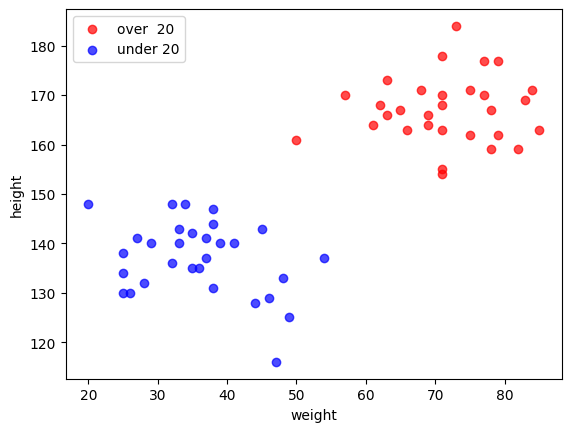

In [3]:
import numpy as np
import matplotlib.pyplot as plt

"""
指定した人数分、20歳以上・20歳以下のダミーデータを作成する関数。
政府統計の国民健康・栄養調査の2019年データを使用し、
20歳以上については身長・体重の平均・標準偏差を参考に適当な正の相関(r=0.4)を持たせる。
20歳以下については10歳の身長体重の平均・標準偏差を参考に適当な正の相関(r=0.2)を持たせることにした。
"""
def sample_data_from_multivariatenormal(n):
    np.random.seed(1234)
    mean_o20 = [167.7,67.4]
    std_o20 = [6.9, 12.0]
    cov = 0.4*std_o20[0]*std_o20[1]
    cov_o20 =  [[std_o20[0]**2, cov], [cov, std_o20[1]**2]]
    data_o20 = np.random.multivariate_normal(mean_o20,cov_o20, n).astype(np.int64).T

    mean_u20 = [138.1, 33.9]
    std_u20 = [7.5, 9.3]
    cov = 0.2*std_u20[0]*std_u20[1]
    cov_u20 =  [[std_u20[0]**2, cov], [cov, std_u20[1]**2]]
    data_u20 = np.random.multivariate_normal(mean_u20,cov_u20, n).astype(np.int64).T
    return data_o20,data_u20

def plot(data_o20,data_u20):
    fig = plt.figure()
    plt.scatter(data_o20[1],data_o20[0],marker="o",color="r",label="over  20",alpha=0.7)
    plt.scatter(data_u20[1],data_u20[0],marker="o",color="b",label="under 20",alpha=0.7)
    plt.ylabel("height")
    plt.xlabel("weight")
    plt.legend()
    plt.show()

num_people = 30
data_o20,data_u20 = sample_data_from_multivariatenormal(num_people)
plot(data_o20,data_u20)

今の場合は、色で20歳以上と20歳未満を塗り分けているため、両者の分類は自明だが、
年齢のラベル(上図の色)は隠して身長と体重のデータのみが与えられた場合に、
その人が20歳以上/未満かを判定する状況を考えよう。

その判定の方法として、最も単純な線形二値分類をこれから定式化する。  
線形二値分類とは、特徴量の線形結合を用いて、2つのカテゴリに分類する方法である。
噛み砕いて言えば、データの特徴量を線や面(高次元の場合は超平面)で分けてやることで、
そのデータがどちらのカテゴリに属するかを判定する方法である。
上の場合は、特徴量が身長と体重の2つだけなので、二次元平面上で境界線を引いてやれば良い。

今の場合、データは明らかに2つの集団(クラスター)に分かれており、境界線の引き方には幾つかの自由度がある。  
適当に3本ほど引いてみよう。

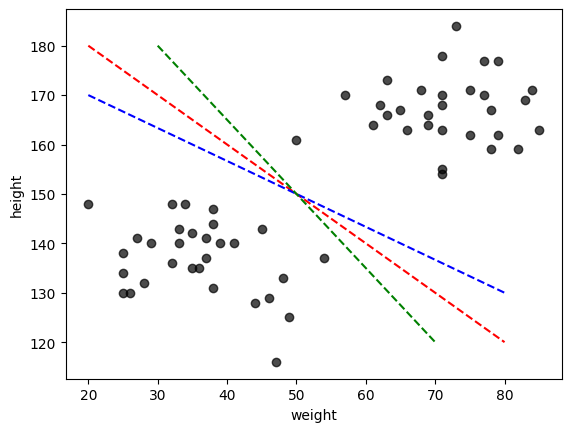

In [4]:
def plot_line(data_o20,data_u20):
    fig = plt.figure()
    plt.scatter(data_o20[1],data_o20[0],marker="o",color="k",alpha=0.7)
    plt.scatter(data_u20[1],data_u20[0],marker="o",color="k",alpha=0.7)
    plt.plot([20,80],[180,120],color="r",linestyle="dashed")    
    plt.plot([20,80],[170,130],color="b",linestyle="dashed")    
    plt.plot([30,70],[180,120],color="g",linestyle="dashed")     
    plt.ylabel("height")
    plt.xlabel("weight")
    plt.show()

plot_line(data_o20,data_u20)

どの直線でも2つの集団を正しく分類することができている。

より一般の身長・体重のデータでは、13-19歳のデータが含まれる上に、
20歳以上でも身長・体重の小さい人や、20歳未満でも身長・体重の大きい人がいるため、
このような境界線でもって全てのデータを分類することはできない。
そのような場合には、身長・体重以外の別の特徴量を用いることでより精度の高い分類が可能になると期待できる。

こうしたより一般(任意の数の特徴量)の場合に対応できるよう、少々抽象的だが、線形二値分類を数式で定式化しておこう。

特徴量の数(次元)を$n$としたとき、ある人のデータは$n$個の成分を持つベクトル$\boldsymbol{x}$で表すことができる。  
例えば、身長と体重の2つの特徴量を持つデータは、身長を$x_1$、体重を$x_2$として、
$\boldsymbol{x} = (x_1, x_2)^T$と表すことができる。※縦ベクトル(あるいは列ベクトル)を表すために、ベクトルの転置を表す記号$^T$を付けた。

このとき、その人が20歳以上かどうかを表すラベルを$y=\{0,1\}$とすると、
線形二値分類は、特徴量の線形結合を用いて、以下のように表すことができる。

:::{admonition} 線形二値分類の式 
:class: important
 
   
$$
y = \begin{cases}
1 & (\boldsymbol{w}^T \boldsymbol{x} + b \geq 0) \\
0 & (\boldsymbol{w}^T \boldsymbol{x} + b < 0)
\end{cases}
$$ (eq:binary-classification)
:::

:::{note}
混乱した人のために、上の$n=2$の場合を考えてみよう。
二次元上の点のうち$w_1 x + w_2 y + b = 0$を満たす$(x,y)$の集まりは、$y=-w_1/w_2 x -b/w_2$となる直線をなす。
したがって、$w_1 x + w_2 y + b$という量の符号を考えれば、境界線に対して点$(x,y)$がどちら側(直線上)にあるかを判定することができる。  
同様に、$n$次元上の点のうち$w_1 x_1 + w_2 x_2 + \cdots + w_n x_n + b = 0$を満たす$(x_1, x_2, \cdots, x_n)$の集まりは$n-1$次元超平面をなす。
したがって、任意の点$\boldsymbol{x}$があるとき、$\boldsymbol{w}^T \boldsymbol{x} + b $という量の正負(または0)を調べれば、境界面に対して点$\boldsymbol{x}$がどちら側(超平面上)にあるかを(人間が頭の中で境界や点を思い浮かべることはできなくても)判定することができる。
:::

**練習問題**

(a). 任意の二次元ベクトル$w$(但し$w_2 \neq 0$)とスカラー$b$、適当な区間で定義されたベクトル$\boldsymbol{x}$を入力に、上の二次元平面上に$w_1 x + w_2 y + b =0$を表す直線をプロットする関数を作成し、$w=(1,1.2), b=-220$の場合について描画せよ。
但し、xの区間は[20,80]とすること(np.linspaceなら始点と終点の2点で良い)

(b). 次に、$w$が未定の場合について、直線$w_1 x + w_2 y + b =0$の係数$w_1,w_2$を求める関数を作成せよ。  
ただし、$(x,y)=(20, 180),(80, 120)$の2点について既知とし、$b=1$とする。

**解答**

(a) xplotに対してyplotを計算するコードを作成し、その出力をプロットしてやれば良い。
但し、$w_2=0$のときは、例外を出すなど、別途対応が必要になる。

(b) $w_1 (x_1-x_2) + w_2 (y_1-y_2) = 0 $から$w_2 = \frac{w_1 (x_2-x_1)}{y_1-y_2}$という関係が得られる。
これを$w_2$に代入すると$w_1 x_1 + \frac{w_1 (x_2-x_1)}{y_1-y_2} (y_1) + 1 = 0$となるので、$w_1=-1/(x_1 + (x_2-x_1)y_1/(y_1-y_2))$と求めることができる。




xplot= [20. 80.]


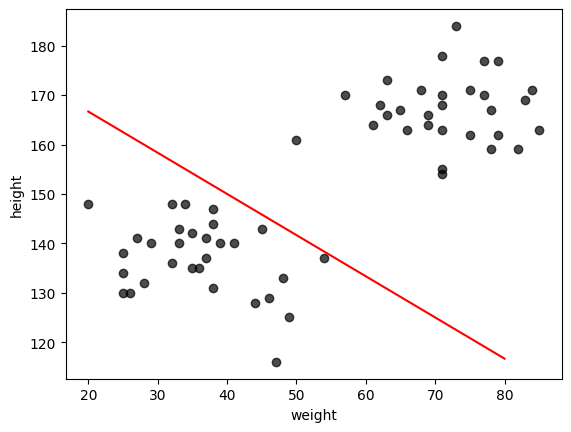

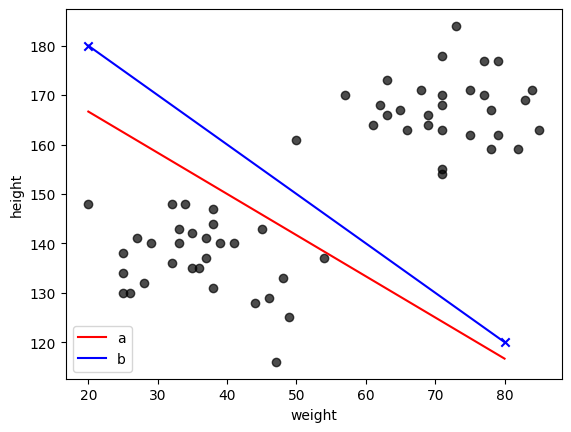

In [23]:
def return_yplot(w, b, x):
    if w[1] == 0:
        raise ValueError("w[1] must be non-zero")
        return None
    else:
        y = - w[0]/w[1]*x - b/w[1]
        return y

def calc_w(xy_known):
    x_1, y_1 = xy_known[0]
    x_2, y_2 = xy_known[1]
    w_1 = -1 / (x_1 + (x_2-x_1)*y_1/(y_1-y_2))
    w_2 = w_1 * (x_2 - x_1)/(y_1 - y_2)
    return np.array([w_1, w_2])
    
xplot = np.linspace(20,80,2) #直線なので2点でよい
print("xplot=",xplot)


# グラフの描画
b = - 220
w = [1.0, 1.2]
yplot_a = return_yplot(w,b,xplot)

fig = plt.figure()
plt.scatter(data_o20[1],data_o20[0],marker="o",color="k",alpha=0.7)
plt.scatter(data_u20[1],data_u20[0],marker="o",color="k",alpha=0.7)
plt.plot(xplot,yplot_a,color="r")
plt.ylabel("height")
plt.xlabel("weight")
plt.show()
plt.close()

#問題B
b = 1
xy_known = [ [20, 180], [80, 120] ]
w = calc_w(xy_known)
yplot_b = return_yplot(w,b,xplot)

fig = plt.figure()
plt.scatter(data_o20[1],data_o20[0],marker="o",color="k",alpha=0.7)
plt.scatter(data_u20[1],data_u20[0],marker="o",color="k",alpha=0.7)
plt.scatter(xy_known[0][0],xy_known[0][1],marker="x",color="b")
plt.scatter(xy_known[1][0],xy_known[1][1],marker="x",color="b")
plt.plot(xplot,yplot_a,color="r",label="a")
plt.plot(xplot,yplot_b,color="b",label="b")
plt.ylabel("height")
plt.xlabel("weight")
plt.legend()
plt.show()
plt.close()

## ロジスティック回帰: 線形二値分類の学習の観点から

上の式{eq}`eq:binary-classification`は、線形結合$\boldsymbol{w}^T \boldsymbol{x} + b$の値が0より大きいか小さいかで、
ラベル$y$を0か1か(今の場合は、20歳以上/未満)に分類する方針を与えている。
しかし、実際の二値分類では、0か1かのどちらかの値を与えるのではなく、
0から1の間の値(≒確率)を与える方が都合が良いことが多い。

上の絵から直感的には、分類直線からの距離が大きいほど、その点が20歳以上(未満)である確率が高くなりそうである。
そこで、分類直線からの距離を表す量$\boldsymbol{w}^T \boldsymbol{x} + b$を、
0から1の間の値に変換する関数$f$を用いて、以下のように変換した量を考えてみよう。

$$
f(\boldsymbol{w}^T \boldsymbol{x} + b)
$$ (eq:binary-classification-probability)

この$f$として、以下のシグモイド(sigmoid)関数(またはロジスティック関数)と呼ばれる関数を用いる。

$$
f(x) = \frac{1}{1 + \exp(-x)}
$$ (eq:sigmoid)

この関数は、$x$が大きいほど1に近づき、$x$が小さいほど0に近づく。実際に図示してみよう。

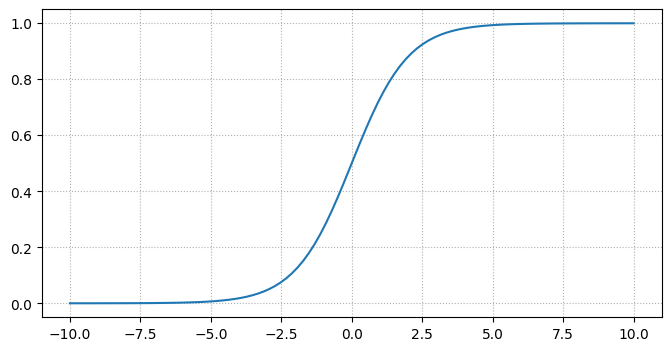

In [6]:
"""
sigmoid関数の定義
実際にはこのようなnaiveな実装だと、xがoverflowを起こすので、引数に応じて評価する式を変えるなどの工夫が必要である。
numpyだと"RuntimeWarning: overflow encountered in exp"と初回に警告を出しつつ、
np.exp(1000)=np.Inf, 1/Inf=0.0として(可能な限り)計算を続けてくれる。
"""
def sigmoid(x):
    return 1/(1+np.exp(-x))

def plot_sigmoid(x,y):
    fig = plt.figure(figsize=(8,4))
    plt.plot(x,y)
    plt.grid(linestyle="dotted")
    plt.show()

x = np.linspace(-10,10,100)
y = sigmoid(x)
plot_sigmoid(x,y)

これにより、$\boldsymbol{w}^T \boldsymbol{x} + b=0$からの距離を関数とした確率を表現することができ、
$f(\boldsymbol{w}^T \boldsymbol{x} + b)=0.5$となる点の集合($\boldsymbol{w}^T \boldsymbol{x} + b=0$)が境界面(今は二次元なので境界線)に対応している事がわかる。


0.5より大きい場合は、1と判定し、0.5より小さい場合は0と判定することで、線形二値分類を実現できる。

また、それだけでなく、２値分類の判定の"自信"のような量を表現することができる点もロジスティック回帰の利点である。


